In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings("ignore")
X_train=pd.read_csv('XTrainTrans.csv')
X_test=pd.read_csv('XTestTrans.csv')
y_train=pd.read_csv('yTrainTrans.csv')
y_test=pd.read_csv('yTestTrans.csv')

In [2]:
X_train.columns

Index(['Latitude', 'Longitude', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA',
       ...
       'ThirdLargestPropertyUseType_33', 'ThirdLargestPropertyUseType_34',
       'ThirdLargestPropertyUseType_35', 'ThirdLargestPropertyUseType_36',
       'ThirdLargestPropertyUseType_37', 'ThirdLargestPropertyUseType_38',
       'ThirdLargestPropertyUseType_39', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)'],
      dtype='object', length=199)

## Enlever les informations relieees a la consommation de l'energie
Ces variables sont calculees a partir de la consommation d'energie. Ce sont donc des variables fortement reliee aux variables cibles et il semble donc logique de ne pas les inclure dans les variables de predictions

In [3]:
y_train.columns

Index(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], dtype='object')

In [4]:
correlated=['PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA']

X_train=X_train.drop(columns=correlated)
X_test=X_test.drop(columns=correlated)

In [5]:
X_train.columns[:15]

Index(['Latitude', 'Longitude', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingType_0', 'BuildingType_1', 'BuildingType_2', 'BuildingType_3',
       'BuildingType_4', 'BuildingType_5'],
      dtype='object')

In [6]:
numeric=['Latitude', 'Longitude', 'ElectricityRatio', 'NaturalGasRatio',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofFloors',
       'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA']

## On travaille sur la prediction de la consommation d'energie

In [7]:
y_consom=y_train['SiteEnergyUse(kBtu)']

In [8]:
y_test_consom=y_test['SiteEnergyUse(kBtu)']

# Regressions lineaires
Nous allons commencer notre etudes des methodes de predictions des methodes les plus simples vers les plus performentes. Nous commencerons donc par les regressions lineaires

## 1- Dummy regression
On commence par cette regression qui predira uniquement la moyenne (c'est la pire regression possible et nous donnera donc une baseline)

In [9]:
import timeit
from sklearn import dummy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
dum = dummy.DummyRegressor(strategy='mean')

In [10]:
score=pd.DataFrame()


In [11]:
score.loc['Model',0]='Dummy'
start_time = timeit.default_timer()
dum.fit(X_train, y_consom)
y_pred_dum = dum.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',0]=elapsed
print ("The time of execution is {:.5f}s".format(elapsed))

The time of execution is 0.00078s


In [12]:
def get_score(y, ypred,i):
    mse=mean_squared_error(y, ypred)
    #score.loc['MSE', i]=mse
    #print("MSE : {:.2f}".format(mse))
    rmse=np.sqrt(mse)
    score.loc['RMSE',i]= rmse
    print("RMSE : {:.2f}".format(rmse))
    mae=mean_absolute_error(y,ypred)
    score.loc['MAE', i]= mae
    print("MAE : {:.2f}".format(mae))


In [13]:
get_score(y_test_consom, y_pred_dum,0)

RMSE : 1.05
MAE : 0.82


In [14]:
score

,0
Model,Dummy
Time,0.000781
RMSE,1.04711
MAE,0.815591


In [15]:
def get_r2(model,X,y,i):
    score.loc['R2',i]= model.score(X, y)
    print("R2 : {:.5f}".format(model.score(X, y)))

In [16]:
get_r2(dum, X_test, y_test_consom,0)

R2 : -0.00122


## Conclusion: 
Dummy Regression nous donne le pire scenario, on voit bien q'avec un R2 negatif et des erreurs assez grande, ce model ne donne pas d'informations sur les predictions

## 2- Linear regression

In [17]:
score.loc['Model', 1]='Linear Regression'
from sklearn import linear_model
start_time = timeit.default_timer()
lr = linear_model.LinearRegression()
lr.fit(X_train,y_consom)
y_pred_base=lr.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time', 1]=elapsed
print ("The time of execution is {:.5f}s".format(elapsed))

The time of execution is 0.02779s


In [18]:
get_score(y_test_consom, y_pred_base,1)

RMSE : 18206953921.12
MAE : 853596602.35


In [19]:
get_r2(lr,X_test, y_test_consom,1)

R2 : -302704216217089212416.00000


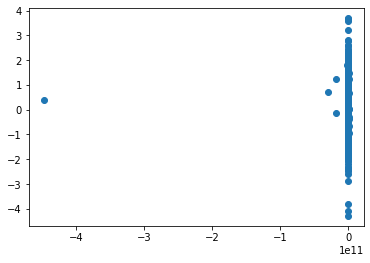

In [20]:
import matplotlib.pyplot as plt
plt.scatter(y_pred_base, y_test_consom)

## Conclusion
La regression lineaire donne des resultats aberrants, pour mieux comprendre la cause de ces scores, on regardes les coefficients des variables de regression

### Coefficients des variables
Afin de comprendre l'importance des variables dans la prediction de la variable cible on regarde les coefficients de la regression. Je vais mettre les coefficients des regressions lineaire Ridge et Lasso dans un meme DataFrame afin de pouvoir comparer la performence et la decision de chaque methode

In [21]:
importance = lr.coef_

In [22]:
imp=pd.DataFrame()
imp['Feature']=X_train.columns
imp['LinearRegression']=importance

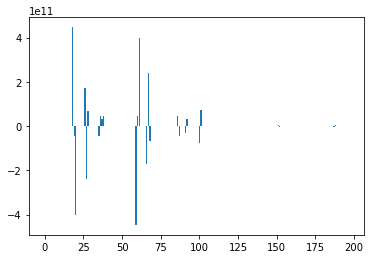

In [23]:
import matplotlib.pyplot as plt
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [24]:
imp.describe()

,LinearRegression
count,1.970000e+02
mean,3.781668e+08
std,6.885705e+10
min,-4.464054e+11
25%,-3.695732e-01
50%,3.521844e-02
75%,3.642684e-01
max,4.464054e+11


## Interpretation 
On voit bien ici que les resultats sont du aux gros poids des coefficients. En effet,  les coefficients ont des poids tres importants et donc agissent d'une facon extreme sur les predictions d'ou les scores tres importants dans les indicateurs d'erreurs. Cela est surtout du au fait qu'il existe des correlations entres les variables. Pour gerer la multicollinearite, on essaie les regressions Ridge et Lasso qui effectuent des regularisations sur l'erreur quadratique (l2) ou lineaire (l1)

In [25]:
negReg=imp.sort_values(by='LinearRegression').head(15)

In [26]:
posReg=imp.sort_values(by='LinearRegression', ascending=False).head(15)

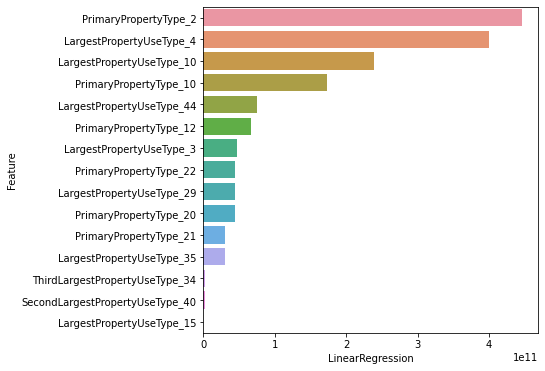

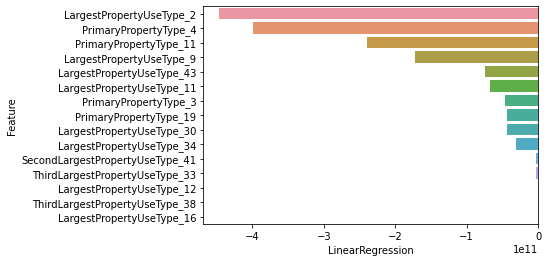

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='LinearRegression',y='Feature', data = posReg) 
plt.show()
ax=sns.barplot(x='LinearRegression',y='Feature', data = negReg) 

## 3- Regression ridge



Je fais dans un premier temps une etude manuel pour trouver le meilleur alpha puis je fais un GridSearch pour optimiser cette recherche. 

Recherche des hyperparametres avec GridSearchCV

In [28]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)
from sklearn.linear_model import Ridge
ridge = Ridge()
from sklearn.model_selection import GridSearchCV
param = {
    'alpha':alphas,
    'fit_intercept':[True,False],
          }
search = GridSearchCV(ridge, param, scoring='r2', n_jobs=-1, cv=5)


In [29]:
searchTable=pd.DataFrame()

In [30]:
searchTable.loc['Model',2]='Ridge'
start_time=timeit.default_timer()
result = search.fit(X_train, y_consom)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',2]=elapsed
print ("The time of execution is {:.2f}s".format(elapsed))

The time of execution is 25.16s


In [31]:
def bestScore(model, i):
    searchTable.loc['Best Score',i]=model.best_score_
    #searchTable.loc['Best Hyperparameters',i]=model.best_params_
    print('Best Score: %s' % model.best_score_)
    print('Best Hyperparameters: %s' % model.best_params_)

In [32]:
bestScore(search,2)

Best Score: 0.7371901737742691
Best Hyperparameters: {'alpha': 3.3700643292719317, 'fit_intercept': False}


In [33]:
Model= result.best_estimator_

In [34]:
score.loc['Model',2]='Ridge'
start_time=timeit.default_timer()
Model.fit(X_train,y_consom)
ypredRidge=Model.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',2]=elapsed
print ("The time of execution is {:.2f}s".format(elapsed))

The time of execution is 0.05s


In [35]:
get_score(y_test_consom,ypredRidge,2)

RMSE : 0.55
MAE : 0.39


In [36]:
get_r2(Model,X_test, y_test_consom, 2)

R2 : 0.72233


## Conclusion
On voit bien que le score de la regression Ridge presente une nette amelioration de la regression lineaire. Nous allons regarder les coefficients des variables par la regression Ridge

In [37]:
importance = Model.coef_
imp['Ridge']=importance


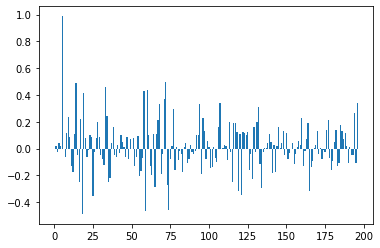

In [38]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [39]:
imp.describe()

,LinearRegression,Ridge
count,1.970000e+02,197.000000
mean,3.781668e+08,0.016796
std,6.885705e+10,0.182995
min,-4.464054e+11,-0.487363
25%,-3.695732e-01,-0.076033
50%,3.521844e-02,0.005316
75%,3.642684e-01,0.107573
max,4.464054e+11,0.987253


On voit bien que les coefficients dans la regression Ridge sont beaucoup plus equilibres

In [40]:
posRidge=imp[['Feature','Ridge']].sort_values(by="Ridge", ascending=False).head(10)

In [41]:
negRidge=imp[['Feature','Ridge']].sort_values(by="Ridge").head(10)

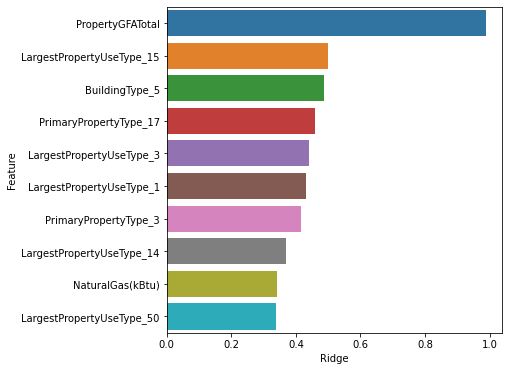

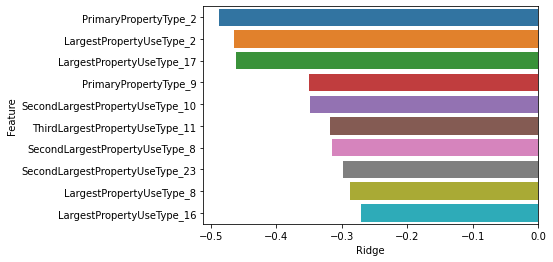

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Ridge',y='Feature', data = posRidge) 
plt.show()
ax=sns.barplot(x='Ridge',y='Feature', data = negRidge) 

# Lasso
La regression Lasso permet de faire une selection de variables en eliminant des variables correlees. Nous allons comparer la performance de la regression Lasso a celle de Ridge

Recherche des hyperparametres avec GridSearchCV

In [43]:
from sklearn.linear_model import Lasso
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)
param = {
    'alpha':alphas,
    'fit_intercept':[True,False],
          }
lasso=Lasso()
search = GridSearchCV(lasso, param, scoring='r2', n_jobs=-1, cv=5)


In [44]:
searchTable.loc['Model',3]='Lasso'
start_time=timeit.default_timer()
result = search.fit(X_train, y_consom)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',3]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 119.06s


In [45]:
bestScore(search,3)

Best Score: 0.735224916128469
Best Hyperparameters: {'alpha': 0.0005484416576121015, 'fit_intercept': False}


In [46]:
Model_lasso= result.best_estimator_

In [47]:
score.loc['Model',3]='Lasso'
start_time=timeit.default_timer()
Model_lasso.fit(X_train,y_consom)
ypred_Lasso=Model_lasso.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',3]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))


The time of execution of above program is 0.31s


In [48]:
get_score(y_test_consom,ypred_Lasso,3 )

RMSE : 0.55
MAE : 0.38


In [49]:
get_r2(Model_lasso,X_test, y_test_consom,3)

R2 : 0.72442


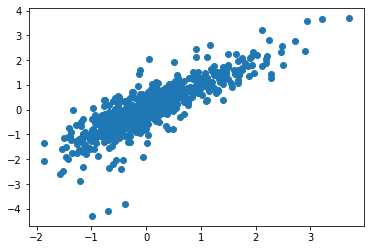

In [50]:
plt.scatter(ypred_Lasso,y_test_consom )

## Conclusion
On voit bien que le score de la regression Lasso est tres proche du score de la regression Ridge, par contre le traietement des coefficients de variables est different

## Coefficients des variables Lasso

In [51]:
importance = Model_lasso.coef_

In [52]:
imp['Lasso']=importance

In [53]:
imp.describe()

,LinearRegression,Ridge,Lasso
count,1.970000e+02,197.000000,197.000000
mean,3.781668e+08,0.016796,0.017998
std,6.885705e+10,0.182995,0.219306
min,-4.464054e+11,-0.487363,-1.022905
25%,-3.695732e-01,-0.076033,0.000000
50%,3.521844e-02,0.005316,0.000000
75%,3.642684e-01,0.107573,0.027244
max,4.464054e+11,0.987253,1.129778


On voit bien ici que pour la regression Lasso il y a des variables dont le coefficient passe a 0. Il y a donc automatiquement une reduction du nombre de variables

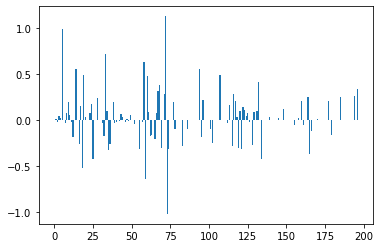

In [54]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [55]:
selected_Lasso=imp[(imp['Lasso']!=0)]['Feature'].values

In [56]:
len(selected_Lasso)

104

Le model Lasso est donc base sur la selection de 82 variables a partir des 193

In [57]:
negLasso=imp[['Feature','Lasso']].sort_values(by='Lasso').head(10)

In [58]:
posLasso=imp[['Feature','Lasso']].sort_values(by='Lasso', ascending=False).head(10)

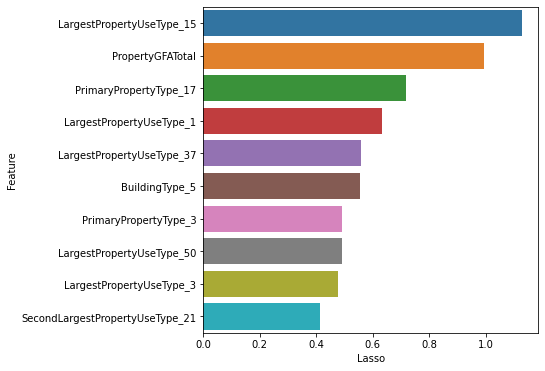

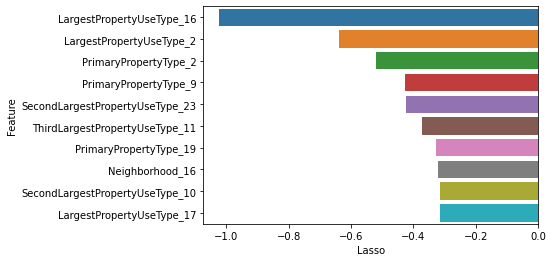

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Lasso',y='Feature', data = posLasso) 
plt.show()
ax=sns.barplot(x='Lasso',y='Feature', data = negLasso) 

# 4- Decision tree regression

In [61]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In [62]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
from sklearn.model_selection import GridSearchCV
search=GridSearchCV(dtr,param_grid=parameters,scoring='r2',cv=3)

In [63]:
searchTable.loc['Model',4]='Decision Tree'
start_time=timeit.default_timer()
search.fit(X_train,y_consom)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',4]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))


The time of execution of above program is 2717.21s


In [64]:
bestScore(search, 4)

Best Score: 0.5749462755806648
Best Hyperparameters: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}


In [65]:
best_tree = search.best_estimator_

In [66]:
score.loc['Model',4]='Decision Tree'
start_time=timeit.default_timer()
best_tree.fit(X_train, y_consom)
y_pred_tree=best_tree.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',4]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 0.03s


In [67]:
get_score(y_test_consom, y_pred_tree,4)

RMSE : 0.71
MAE : 0.53


In [68]:
get_r2(best_tree, X_test, y_test_consom, 4)

R2 : 0.54467


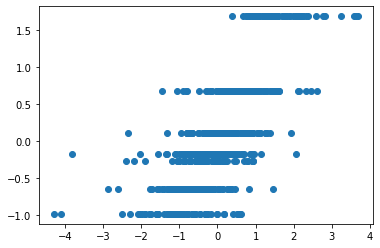

In [69]:
plt.scatter(y_test_consom, y_pred_tree)

## Feature importance

In [70]:
importance=best_tree.feature_importances_

In [71]:
imp['Decision Tree']=importance

In [72]:
tree_feat=imp[['Feature','Decision Tree']][imp['Decision Tree']!=0].sort_values(by='Decision Tree', ascending=False)

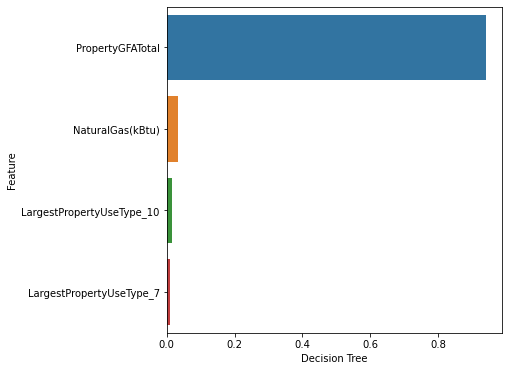

In [73]:
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Decision Tree',y='Feature', data = tree_feat) 
plt.show()

# 5- Random Forest Regression

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()

In [75]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [76]:
search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [77]:
searchTable.loc['Model',5]='Random Forest'
start_time=timeit.default_timer()
search.fit(X_train, y_consom)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',5]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))


Fitting 3 folds for each of 80 candidates, totalling 240 fits
The time of execution of above program is 1404.06s


In [78]:
bestScore(search, 5)

Best Score: 0.7045090700437974
Best Hyperparameters: {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [79]:
best_forest = search.best_estimator_

In [80]:
score.loc['Model',5]='Random Forest'
start_time=timeit.default_timer()
best_forest.fit(X_train, y_consom)
y_pred_forest=best_forest.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time', 5]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 46.88s


In [81]:
get_score(y_test_consom, y_pred_forest,5)

RMSE : 0.59
MAE : 0.40


In [82]:
get_r2(best_forest, X_test, y_test_consom, 5)

R2 : 0.68608


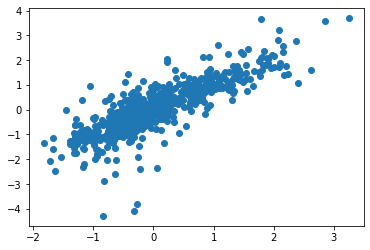

In [83]:
plt.scatter(y_pred_forest, y_test_consom)

## Feature importance

In [84]:
importance=best_forest.feature_importances_
imp['Random Forest']=importance
imp.describe()

,LinearRegression,Ridge,Lasso,Decision Tree,Random Forest
count,1.970000e+02,197.000000,197.000000,197.000000,197.000000
mean,3.781668e+08,0.016796,0.017998,0.005076,0.005076
std,6.885705e+10,0.182995,0.219306,0.067005,0.047982
min,-4.464054e+11,-0.487363,-1.022905,0.000000,0.000000
25%,-3.695732e-01,-0.076033,0.000000,0.000000,0.000032
50%,3.521844e-02,0.005316,0.000000,0.000000,0.000285
75%,3.642684e-01,0.107573,0.027244,0.000000,0.001169
max,4.464054e+11,0.987253,1.129778,0.939964,0.671709


In [85]:
forest_feat=imp[['Feature', 'Random Forest']][imp['Random Forest']>0.005].sort_values(by='Random Forest', ascending=False).head(10)

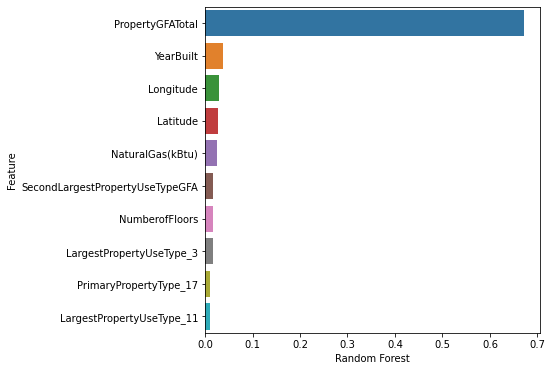

In [86]:
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Random Forest',y='Feature', data = forest_feat) 
plt.show()

# 6- XgBoost

In [87]:
import xgboost as xgb
from scipy.stats import uniform,loguniform, randint

In [88]:
param_grid = {
    "learning_rate": [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
    "n_estimators": [200, 500, 1000, 1500, 2000]
}

# Random
search = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_grid,
                        n_iter = 80,  cv=3, n_jobs=8, scoring='r2')

In [89]:
searchTable.loc['Model', 6]='XgBoost'
start_time=timeit.default_timer()
model_xgboost = search.fit(X_train, y_consom)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',6]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 665.04s


In [90]:
bestScore(model_xgboost, 6)

Best Score: 0.7160218650151009
Best Hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [91]:
best_boost= model_xgboost.best_estimator_

In [92]:
score.loc['Model',6]='XgBoost'
start_time=timeit.default_timer()
best_boost.fit(X_train, y_consom)
ypreds_boost = best_boost.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',6]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 1.41s


In [93]:
get_score(y_test_consom, ypreds_boost,6)

RMSE : 0.57
MAE : 0.39


In [94]:
get_r2(best_boost,X_test, y_test_consom, 6)

R2 : 0.70051


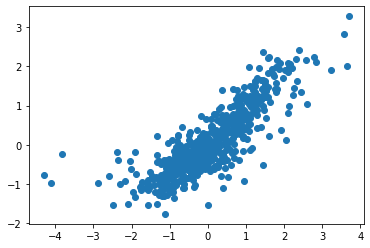

In [95]:
plt.scatter(y_test_consom, ypreds_boost)

In [96]:
importance=best_boost.feature_importances_
imp['XgBoost']=importance
imp.describe()

,LinearRegression,Ridge,Lasso,Decision Tree,Random Forest,XgBoost
count,1.970000e+02,197.000000,197.000000,197.000000,197.000000,197.000000
mean,3.781668e+08,0.016796,0.017998,0.005076,0.005076,0.005076
std,6.885705e+10,0.182995,0.219306,0.067005,0.047982,0.011004
min,-4.464054e+11,-0.487363,-1.022905,0.000000,0.000000,0.000000
25%,-3.695732e-01,-0.076033,0.000000,0.000000,0.000032,0.000000
50%,3.521844e-02,0.005316,0.000000,0.000000,0.000285,0.000935
75%,3.642684e-01,0.107573,0.027244,0.000000,0.001169,0.005076
max,4.464054e+11,0.987253,1.129778,0.939964,0.671709,0.102260


In [97]:
xgb_feat=imp[['Feature','XgBoost']][imp['XgBoost']>0.01].sort_values(by='XgBoost', ascending=False).head(10)

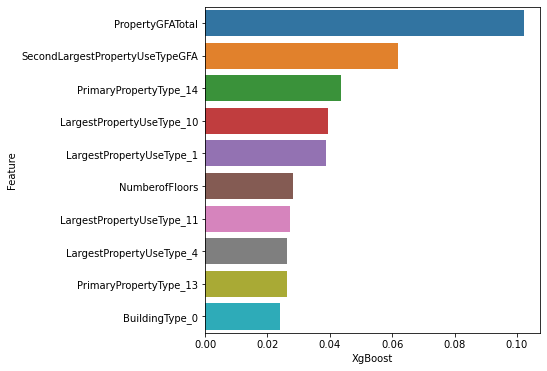

In [98]:
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='XgBoost',y='Feature', data = xgb_feat) 
plt.show()

# Synthese des resultats de performence

## Scores de validation sur Test set

In [102]:
score=score.transpose()
score1=score.drop(columns=['MAE'])
score1.transpose()

,0,1,2,3,4,5,6
Model,Dummy,Linear Regression,Ridge,Lasso,Decision Tree,Random Forest,XgBoost
Time,0.000781,0.027789,0.04807,0.314054,0.032121,46.877624,1.409988
RMSE,1.04711,18206953921.124996,0.551431,0.54935,0.706141,0.586327,0.572685
R2,-0.001218,-302704216217089212416.0,0.722331,0.724424,0.54467,0.686077,0.700514


## Temps de recherche des hyperparametres et score R2 par validation croisee sur train set

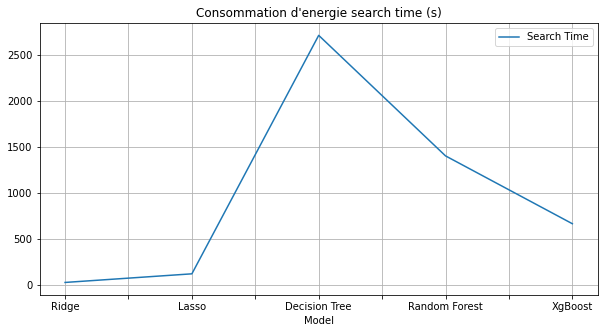

In [103]:
searchTable=searchTable.transpose()
ax=searchTable[["Model","Search Time"]].plot(kind="line", x="Model", figsize=(10,5), grid=True, title="Consommation d'energie search time (s)")

In [104]:
searchTable.transpose()

,2,3,4,5,6
Model,Ridge,Lasso,Decision Tree,Random Forest,XgBoost
Search Time,25.160186,119.05885,2717.212877,1404.059603,665.040201
Best Score,0.73719,0.735225,0.574946,0.704509,0.716022


In [105]:
comparaison=pd.DataFrame()
comparaison['Model']=searchTable['Model']
comparaison['Test']=score['R2']
comparaison['Train']=searchTable['Best Score']
comparaison

,Model,Test,Train
2,Ridge,0.722331,0.73719
3,Lasso,0.724424,0.735225
4,Decision Tree,0.54467,0.574946
5,Random Forest,0.686077,0.704509
6,XgBoost,0.700514,0.716022


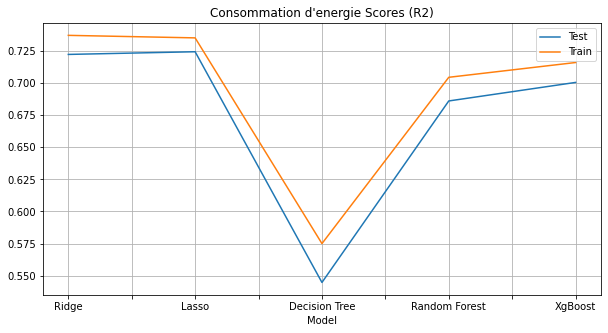

In [106]:
ax=comparaison.plot(kind="line", x="Model", figsize=(10,5), grid=True, title="Consommation d'energie Scores (R2)")
